In [1]:
import subprocess
import pdb

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

# import nest_asyncio
# nest_asyncio.apply()
# import datalad.api as dl

import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")


/Users/gracer/opt/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/gracer/opt/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.

Autosaving every 5 seconds


# Functions to register the images
Normal registrations lead to severe stretching an distortion of the functional images. Therefore, the ROIs (in MNI asym 09) and the T1 were registered to the functional image. While not standard, because this is an ROI analysis not whole brain we feel that this method is the best way to get the true areas of the ROIs in the functional images

In [2]:
def get_t1(strc, basepath):
    T1 = strc
    sub = strc.split('/')[-1].split('.')[0].split('_')[-1]
    output_path = os.path.join(basepath,'derivatives','reg')
    return([sub,output_path,T1])

In [3]:
def get_example_func(reference,T1,output_path,sub,style):
    example_func = '%s/%s_%s_example_func.nii.gz'%(output_path,sub,style)
    example_func_cmd = '/usr/local/fsl/bin/fslroi %s %s 300 1'%(reference,example_func)
    example_func_cmd_list= example_func_cmd.split(' ')
    subprocess.call(example_func_cmd_list)
    print(example_func)
    return(example_func)

In [4]:
def func_thresh(example_func,output_path,sub):
    # threshold out extra bullshit
    print('thresholding')
    x = example_func.split('.')[0]
    x = '%s_thr'%x
    print(x)
    thr_cmd = '/usr/local/fsl/bin/fslmaths %s -thr 200 %s'%(example_func,x)
    thr_cmd_list = thr_cmd.split(' ')
    subprocess.call(thr_cmd_list)
    #example_func_thr = '%s/%s_example_func_thr.nii.gz'%(output_path,sub)
    example_func_thr = '%s.nii.gz'%x
    return(example_func_thr)

In [28]:
def heavy_lifting(T1,example_func_thr, output_path, sub, basepath):
# register the T1 to the BOLD
    ## get the matrix
    print('welcome to the matrix')
    x = example_func.split('.')[0]
    outp = '%s_T12func.mat'%x
    cmd = 'flirt -in %s -ref %s -out outputvol -omat %s'%(T1,example_func_thr,outp)
    cmd_list = cmd.split(' ')
    subprocess.call(cmd_list)
    ## use the matrix
    print('neo use the matrix')
    matrix = outp
    y = '%s_T12func'%x
    flirt_cmd = 'flirt -in %s -ref %s -applyxfm -init %s -out %s'%(T1, example_func_thr,matrix,y)
    flrt_cmd_list = flirt_cmd.split(' ')
    subprocess.call(flrt_cmd_list)
    # Register the atlas image to the T1
    print('registering')
    T1_reg = y
    hi2std = '%s_highres2standard'%x
    hi2stdmat = '%s_highres2standard.mat'%x
    standard = os.path.join(basepath,'atlases','CIT168_Reinf_Learn_v1.1.0','MNI152-Nonlin-Asym-2009c','CIT168toMNI152-2009c_T1w_brain.nii.gz')
    s2t1_cmd = '/usr/local/fsl/bin/flirt -in %s -ref %s -out %s -omat %s -cost corratio -dof 12 -searchrx -90 90 -searchry -90 90 -searchrz -90 90 -interp trilinear'%(standard,T1_reg, hi2std,hi2stdmat)
    s2t1_cmd_list = s2t1_cmd.split(' ')
    subprocess.call(s2t1_cmd_list)
    return(hi2stdmat, T1_reg)

In [6]:
def roi_dir(mask_dir, sub, style):
    roi_out = os.path.join(mask_dir,'%s_%s'%(style,sub))
    try:
        os.makedirs(roi_out)
    except FileExistsError:
        pass
    return(roi_out)


In [7]:
def roi_create(roi_orig, roi_out, T1_reg, matrix):
    roi = roi_orig.split('/')[-1].split('_')[-1].split('.')[0]
    print(roi)
    ### align with the standard brain
    outp = '%s/%s_roi2T1'%(roi_out,roi)
    roi_cmd = 'flirt -in %s -ref %s -applyxfm -init %s -out %s'%(roi_orig,T1_reg,matrix,outp)
    print(roi_cmd)
    roi_cmd_list = roi_cmd.split(' ')
    subprocess.call(roi_cmd_list)
    return(outp, roi)

In [8]:
def roi_thresh(roi,roi_out,thresh):
    inp ='%s/%s_roi2T1.nii.gz'%(roi_out,roi)
    oot = '%s/%s_%s_roi2T1_thresh'%(roi_out,roi,thresh)
    print(thresh)
    thresh_cmd = '/usr/local/fsl/bin/fslmaths %s -thr %s %s'%(inp,thresh,oot)
    thresh_cmd_list = thresh_cmd.split(' ')
    subprocess.run(thresh_cmd_list)
    num = roi.split('l')[1]
    oupt = '%s/%s_%s_roi2T1_thresh_bin'%(roi_out,roi,thresh)
    bin_cmd = 'fslmaths %s -bin -mul %s %s'%(oot,num,oupt)
    bin_cmd_list = bin_cmd.split(' ')
    subprocess.run(bin_cmd_list)
    return(oupt)

In [41]:
def roi_merger(path2rois, thresh):
    ## make a total brain
    rois = glob.glob(os.path.join(path2rois,'vol*_%s_roi2T1_thresh_bin.nii.gz'%thresh))
    print(len(rois))
    finalgirl = os.path.join(path2rois,'total_rois')
    rois.append(finalgirl)
    roi_cmd2 = 'fslmaths %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s %s'%tuple(rois)
    roi_cmd2_list=roi_cmd2.split(' ')
    subprocess.run(roi_cmd2_list)

In [10]:
def extractor(nifti, output):
    bet_cmd = 'bet %s %s -F'%(nifti, output)
    subprocess.run(['bet','%s'%nifti,'%s'%output,'-F'])

In [15]:
basepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data'

In [12]:
tasks = ['base','clamp']

need to register the two new ROIS to the same template as the others

In [19]:
inp = os.path.join(basepath,'atlases','anatomical.nii.gz')
out = os.path.join(basepath,'atlases','anatomical_asym.nii.gz')
ref = os.path.join(basepath,'atlases','CIT168_Reinf_Learn_v1.1.0','MNI152-Nonlin-Asym-2009c','CIT168toMNI152-2009c_T1w_brain.nii.gz')
outmat = os.path.join(basepath,'atlases','anatomical_asym.mat')
fl_cmd = 'flirt -in %s -ref %s -out %s -omat %s -dof 6'%(inp, ref, out,outmat)
fl_cmd_list = fl_cmd.split(' ')
subprocess.run(fl_cmd_list)


CompletedProcess(args=['flirt', '-in', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/anatomical.nii.gz', '-ref', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/CIT168_Reinf_Learn_v1.1.0/MNI152-Nonlin-Asym-2009c/CIT168toMNI152-2009c_T1w_brain.nii.gz', '-out', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/anatomical_asym.nii.gz', '-omat', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/anatomical_asym.mat', '-dof', '6'], returncode=0)

In [21]:
inp = os.path.join(basepath,'atlases','dlpfc_association-test_z_FDR_0.01.nii.gz')
out = os.path.join(basepath,'atlases','atlas','CIT168toMNI152_prob_atlas_bilat_1mm__vol17')
ref = os.path.join(basepath,'atlases','CIT168_Reinf_Learn_v1.1.0','MNI152-Nonlin-Asym-2009c','CIT168toMNI152-2009c_T1w_brain.nii.gz')
inmat = os.path.join(basepath,'atlases','anatomical_asym.mat')
fl2_cmd = 'flirt -in %s -ref %s -out %s -init %s -applyxfm'%(inp, ref, out, inmat)
fl2_cmd_list = fl2_cmd.split(' ')
subprocess.run(fl2_cmd_list)


CompletedProcess(args=['flirt', '-in', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/dlpfc_association-test_z_FDR_0.01.nii.gz', '-ref', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/CIT168_Reinf_Learn_v1.1.0/MNI152-Nonlin-Asym-2009c/CIT168toMNI152-2009c_T1w_brain.nii.gz', '-out', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol17', '-init', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/anatomical_asym.mat', '-applyxfm'], returncode=0)

In [23]:
inp = os.path.join(basepath,'atlases','visual_cortex_association-test_z_FDR_0.01.nii.gz')
out = os.path.join(basepath,'atlases','atlas','CIT168toMNI152_prob_atlas_bilat_1mm__vol18')
ref = os.path.join(basepath,'atlases','CIT168_Reinf_Learn_v1.1.0','MNI152-Nonlin-Asym-2009c','CIT168toMNI152-2009c_T1w_brain.nii.gz')
inmat = os.path.join(basepath,'atlases','anatomical_asym.mat')
fl2_cmd = 'flirt -in %s -ref %s -out %s -init %s -applyxfm'%(inp, ref, out, inmat)
fl2_cmd_list = fl2_cmd.split(' ')
subprocess.run(fl2_cmd_list)


CompletedProcess(args=['flirt', '-in', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/visual_cortex_association-test_z_FDR_0.01.nii.gz', '-ref', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/CIT168_Reinf_Learn_v1.1.0/MNI152-Nonlin-Asym-2009c/CIT168toMNI152-2009c_T1w_brain.nii.gz', '-out', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol18', '-init', '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/anatomical_asym.mat', '-applyxfm'], returncode=0)

# Skull stripping

In [17]:
for task in tasks:
    print(task)
    for nifti in glob.glob(os.path.join(basepath,'func','%s'%task,'*.nii')):
        print(nifti)
        name = nifti.split('/')[-1].split('.')[0]
        output = os.path.join(basepath,'derivatives','BET','%s_brain'%name)
        extractor(nifti, output)

base
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/base/swu20004_base.nii
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/base/swu20008_base.nii
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/base/swu20002_base.nii
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/base/swu20003_base.nii
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/base/swu20010_base.nii
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/base/swu20001_base.nii
clamp
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/clamp/swu20010_clamp.nii
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/clamp/swu20004_clamp.nii
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/clamp/swu20002_clamp.nii
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/clamp/swu20008_clamp.nii
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/clamp/swu20003_clamp.nii
/Users/gracer/Documents/BBC_21-2939_prepro_data/func/clamp/swu20001_clamp.nii


# Registration

## Try not to run unless you got time

In [29]:
for strc in glob.glob(os.path.join(basepath, 'anat','ss_t1*.nii')):
    sub,output_path,T1 = get_t1(strc,basepath)
    print(sub)
    for task in tasks:
        for ref in glob.glob(os.path.join(basepath,'derivatives','BET','%s'%task,'*%s*_brain.nii.gz'%sub)):
            style = ref.split('_')[4]
            example_func = get_example_func(ref,T1,output_path,sub,style)
            example_func_thr = func_thresh(example_func,output_path,sub)
            matrix, T1_reg = heavy_lifting(T1, example_func_thr, output_path, sub, basepath)
            mask_dir = os.path.join(basepath,'atlases','atlas')
            for x in glob.glob(os.path.join(mask_dir,'CIT168toMNI152_prob_atlas_bilat_1mm__vol*.nii.gz')):
                roi_orig = os.path.join(mask_dir,x)
                roi_out = roi_dir(mask_dir, sub,style)
                roi_path,roi = roi_create(roi_orig, roi_out, T1_reg, matrix)
                roithr = roi_thresh(roi,roi_out,'0.5')


20004
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func.nii.gz
thresholding
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func_thr
welcome to the matrix
neo use the matrix
registering
vol17
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol17.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20004/vol17_roi2T1
0.5
vol8
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol8.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/d

0.5
vol4
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol4.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20004/vol4_roi2T1
0.5
vol6
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol6.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20004/vol6_roi2T1
0.5
vol15
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_

0.5
vol15
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol15.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20010_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20010_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20010/vol15_roi2T1
0.5
vol2
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol2.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20010_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20010_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20010/vol2_roi2T1
0.5
vol11
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atl

0.5
vol11
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol11.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20010_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20010_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20010/vol11_roi2T1
0.5
vol13
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol13.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20010_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20010_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20010/vol13_roi2T1
0.5
vol5
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_

0.5
vol5
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol5.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20003/vol5_roi2T1
0.5
vol16
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol16.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20003/vol16_roi2T1
0.5
vol18
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atl

0.5
vol18
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol18.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20003/vol18_roi2T1
0.5
vol14
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol14.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20003/vol14_roi2T1
0.5
vol7
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_

0.5
vol7
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol7.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20002/vol7_roi2T1
0.5
vol3
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol3.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20002/vol3_roi2T1
0.5
vol1
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_b

0.5
vol1
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol1.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20002/vol1_roi2T1
0.5
vol12
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol12.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20002/vol12_roi2T1
0.5
20001
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_base_example_func.n

0.5
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_clamp_example_func.nii.gz
thresholding
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_clamp_example_func_thr
welcome to the matrix
neo use the matrix
registering
vol17
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol17.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20001/vol17_roi2T1
0.5
vol8
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol8.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_da

0.5
vol4
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol4.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20008_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20008_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20008/vol4_roi2T1
0.5
vol6
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol6.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20008_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20008_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20008/vol6_roi2T1
0.5
vol15
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_

0.5
vol15
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol15.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20008_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20008_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20008/vol15_roi2T1
0.5
vol2
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol2.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20008_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20008_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20008/vol2_roi2T1
0.5
vol11
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_pr

Exlcuding the PBP, VTA, SNr due to low signal

In [43]:
for path2rois in glob.glob(os.path.join('/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas','*_*/')):
    print(path2rois)
    roi_merger(path2rois, '0.5')

/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20002/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20002/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20004/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20003/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20003/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20004/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20010/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20010/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20008/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20008/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20001/
16
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20001/
16


# Parcellation 

In [44]:
def parcellator(basepath, func, corrlabel):
    print("starting parcellation")
    corrtxt = os.path.join(basepath,'corrlabel_ts.txt')
    cmd = 'fslmeants -i %s --label=%s -o %s'%(func, corrlabel, corrtxt)
    cmd_list = cmd.split(' ')
    print(cmd_list)
    subprocess.run(cmd_list)

In [45]:
outpath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output'
for task in tasks:
    for func in glob.glob(os.path.join(basepath,'derivatives','BET','%s'%task,'*_brain.nii.gz')):
        sub = func.split('/')[-1].split('_')[0].split('u')[-1]
        style = func.split('/')[-1].split('_')[1]
        print(sub)
        print(style)
        try:
            op = os.path.join(outpath,style,sub)
            os.makedirs(op)
        except FileExistsError:
            pass
        corrlabel = os.path.join('/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas','%s_%s'%(style,sub),'total_rois.nii.gz')
        parcellator(op, func, corrlabel)


20010
base
starting parcellation
['fslmeants', '-i', '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/BET/base/swu20010_base_brain.nii.gz', '--label=/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20010/total_rois.nii.gz', '-o', '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20010/corrlabel_ts.txt']
20008
base
starting parcellation
['fslmeants', '-i', '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/BET/base/swu20008_base_brain.nii.gz', '--label=/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20008/total_rois.nii.gz', '-o', '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20008/corrlabel_ts.txt']
20003
base
starting parcellation
['fslmeants', '-i', '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/BET/base/swu20003_base_brain.nii.gz', '--label=/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20003/total_rois.nii.gz', '-o', '/Users/gracer/Documents

# Correlations

In [46]:
from scipy import stats

In [47]:
def correlations(outpath, txtfile):
    print('starting correlation')
    rtxt = os.path.join(outpath,'new_r_matrix.csv')
    ztxt = os.path.join(outpath,'new_zr_matrix.csv')
    corrtxt = os.path.join(outpath,txtfile)
    
    if os.path.isfile(corrtxt):        
#         timeseries = pd.read_csv(corrtxt, header=None,  skiprows=[0])
        timeseries = pd.read_csv(corrtxt, header = None, sep = '  ')
#         pdb.set_trace()
        timeseries = timeseries.drop([0], 1)
        timeseries = timeseries.apply(pd.to_numeric)
#         pdb.set_trace()
        myres = timeseries.corr(method='pearson')

        

        zrmaps = stats.zscore(myres, nan_policy='omit')
        
        pd.DataFrame(zrmaps).to_csv(ztxt, index=False, header= False)
        pd.DataFrame(myres).to_csv(rtxt, index=False, header= False)



# Standardizing the timeseries (brain and insulin seperately)

Switch to both robust, then seperate the negative (abs) and postive values, then run through the pipeline.
4/27 had to switch both to standard cause robust obliterated the insulin

In [85]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [221]:
def combo(path2ts, path2insulin, outpath, instatus):
    prets = pd.read_csv(path2ts, sep = '  ', header = None)
    transformer = StandardScaler().fit(prets)
    ts = pd.DataFrame(data = transformer.transform(prets))
    ts = ts.set_axis(heads, axis=1, inplace=False)
    ts['TR'] = ts.index
    ts['TR'] = pd.to_datetime(ts['TR'], unit='s')
    ts_downsamp = ts.set_index('TR').resample('60S').mean().dropna().reset_index()
    ts_downsamp = ts_downsamp.rename({'TR': 'time'}, axis=1)
    df = ts_downsamp
    
    if instatus == "clamp":
        in_ts = pd.read_csv(path2insulin, sep = ',', encoding='latin-1')
        ins = np.array(in_ts['insulin_uIU_mL']).reshape(-1, 1)
        inscaler = StandardScaler()
        X = pd.DataFrame(inscaler.fit_transform(ins))
        
        gluc = np.array(in_ts['glucose_mg_dL']).reshape(-1, 1)
        gluscaler = StandardScaler()
        Y = pd.DataFrame(gluscaler.fit_transform(gluc))

        in_ts['insulin_uIU_mL'] = X
        in_ts['glucose_mg_dL'] = Y
        
        in_ts['time'] = in_ts['time'] - 1
        in_ts['time'] = pd.to_datetime(in_ts['time'], unit='m')

        df = pd.merge(df, in_ts, on='time', how='outer')
        df = df.drop(['label','sex','pid'], 1)
        df.drop(df.index[:4], inplace=True)
#         pdb.set_trace()
        
    fp = outpath
    df.to_csv(fp, index=False)

In [222]:
labels = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/CIT168_Reinf_Learn_v1.1.0/labels.csv'
basepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base'
clamppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp'
ppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/'

In [223]:
ROI_names = pd.read_csv(labels,sep = ',')
heads = list(ROI_names['ROI'])

In [224]:
import pdb

In [225]:
for task in tasks:
    for sub_path in glob.glob(os.path.join(ppath,'%s'%task,'*')):
        print(sub_path)
        sub = sub_path.split('/')[-1]
        style = sub_path.split('/')[-2]
        path2ts = os.path.join(sub_path,'corrlabel_ts.txt')
        path2insulin = os.path.join('/Users/gracer/Documents/BBC_21-2939_insulin','%s.csv'%sub)
        outpath = os.path.join(sub_path,'total_ts.csv')
        combo(path2ts, path2insulin, outpath, style)

/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20008
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20001
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20002
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20003
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20004
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20010
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20008
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20001
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20003
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20004
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20010


In [226]:
for task in tasks:
    for outpath in glob.glob(os.path.join(ppath,'%s'%task,'*')):
        sub = outpath.split('/')[-1]
        print(sub)
        txtfile = 'corrlabel_ts.txt'
        correlations(outpath, txtfile)

20008
starting correlation
20001
starting correlation
20002
starting correlation
20003
starting correlation
20004
starting correlation
20010
starting correlation
20008
starting correlation
20001
starting correlation
20002
starting correlation
20003
starting correlation
20004
starting correlation
20010
starting correlation


In [89]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 5 seconds


In [64]:
labels = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/CIT168_Reinf_Learn_v1.1.0/labels.csv'
basepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base'
clamppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp'
ppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/'

In [285]:
sub_timeseries_w_na = {}
for txtfile in glob.glob(os.path.join(clamppath,'*','total_ts.csv')):
    print(txtfile)
    df = pd.read_csv(txtfile)
    sub = txtfile.split('/')[-2]
#     df.reset_index(inplace=True, drop=True)
    df = df.set_index('time')
    df = df.drop(['PBP','VTA','SNr','glucose_mg_dL'], 1)
    sub_timeseries_w_na[sub] = df


/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20008/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20001/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20003/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20004/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20010/total_ts.csv


In [286]:
sub_timeseries_w_na['20001']

,Pu,Ca,NAC,EXA,GPe,GPi,SNc,RN,VeP,HN,HTH,MN,STH,dlPFC,Viz,insulin_uIU_mL
time,,,,,,,,,,,,,,,,
1970-01-01 00:04:00,-0.529755,0.035051,-0.388934,0.582089,0.227828,0.785562,-0.386364,-0.052206,-0.193487,0.126828,0.257048,-0.032557,0.490021,-0.644151,-0.380644,0.611722
1970-01-01 00:05:00,-0.465489,0.048946,-0.480059,0.503299,0.240455,0.658980,-0.441394,0.097683,-0.250518,0.132839,0.083343,-0.068215,0.523836,-0.750303,-0.437386,-0.136760
1970-01-01 00:06:00,-0.169974,0.308181,-0.426374,0.564867,0.457678,0.621954,-0.255568,0.405967,-0.136457,0.951806,-0.207620,-0.393189,0.742639,-0.789411,-0.685732,-1.384230
1970-01-01 00:07:00,-0.100205,0.581125,-0.563821,0.820613,0.407295,0.517576,0.053080,0.181258,-0.306335,1.073524,-0.682080,-0.689799,0.510765,-1.057907,-0.637247,0.694887
1970-01-01 00:08:00,-0.373400,0.147540,-0.859065,0.500500,0.128888,0.147639,-0.433419,-0.194002,-0.532637,0.517528,-1.017030,-0.851340,0.161532,-1.271938,-1.113222,1.443369
1970-01-01 00:09:00,-0.117644,0.501546,-0.742474,0.643012,0.282142,0.257291,-0.185384,0.057795,-0.482887,0.745938,-0.888711,-0.877003,0.323788,-1.122192,-0.159181,1.692863
1970-01-01 00:10:00,-0.359854,0.147420,-0.994826,0.368322,-0.009789,0.055392,-0.552252,-0.312757,-0.760152,0.250049,-1.102142,-0.931030,-0.089949,-1.413319,-0.817347,-0.968406
1970-01-01 00:11:00,-0.162124,0.421497,-0.813587,0.638922,0.193043,0.288093,-0.100047,-0.027101,-0.672179,0.549085,-0.933317,-0.768679,0.226889,-1.177570,-0.108016,0.445393
1970-01-01 00:12:00,-0.315561,0.315088,-0.853950,0.541187,0.147704,0.166626,-0.411088,-0.066410,-0.718896,0.457421,-0.926777,-0.836483,-0.001007,-1.404774,-1.050298,1.609698


In [91]:
def get_subject_roi(data, roi):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub][roi]
    return pd.DataFrame(sub_rois)

In [92]:
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state

In [93]:
sub_rois= sub_rois.dropna()

In [94]:
heady = list(sub_timeseries['20001'].columns.values)

In [287]:
sub_timeseries = {}
for sub,data in sub_timeseries_w_na.items():
    print(sub)
    sub_timeseries[sub] = data.dropna()

20008
20001
20002
20003
20004
20010


In [288]:
sub_timeseries['20001']

,Pu,Ca,NAC,EXA,GPe,GPi,SNc,RN,VeP,HN,HTH,MN,STH,dlPFC,Viz,insulin_uIU_mL
time,,,,,,,,,,,,,,,,
1970-01-01 00:04:00,-0.529755,0.035051,-0.388934,0.582089,0.227828,0.785562,-0.386364,-0.052206,-0.193487,0.126828,0.257048,-0.032557,0.490021,-0.644151,-0.380644,0.611722
1970-01-01 00:05:00,-0.465489,0.048946,-0.480059,0.503299,0.240455,0.658980,-0.441394,0.097683,-0.250518,0.132839,0.083343,-0.068215,0.523836,-0.750303,-0.437386,-0.136760
1970-01-01 00:06:00,-0.169974,0.308181,-0.426374,0.564867,0.457678,0.621954,-0.255568,0.405967,-0.136457,0.951806,-0.207620,-0.393189,0.742639,-0.789411,-0.685732,-1.384230
1970-01-01 00:07:00,-0.100205,0.581125,-0.563821,0.820613,0.407295,0.517576,0.053080,0.181258,-0.306335,1.073524,-0.682080,-0.689799,0.510765,-1.057907,-0.637247,0.694887
1970-01-01 00:08:00,-0.373400,0.147540,-0.859065,0.500500,0.128888,0.147639,-0.433419,-0.194002,-0.532637,0.517528,-1.017030,-0.851340,0.161532,-1.271938,-1.113222,1.443369
1970-01-01 00:09:00,-0.117644,0.501546,-0.742474,0.643012,0.282142,0.257291,-0.185384,0.057795,-0.482887,0.745938,-0.888711,-0.877003,0.323788,-1.122192,-0.159181,1.692863
1970-01-01 00:10:00,-0.359854,0.147420,-0.994826,0.368322,-0.009789,0.055392,-0.552252,-0.312757,-0.760152,0.250049,-1.102142,-0.931030,-0.089949,-1.413319,-0.817347,-0.968406
1970-01-01 00:11:00,-0.162124,0.421497,-0.813587,0.638922,0.193043,0.288093,-0.100047,-0.027101,-0.672179,0.549085,-0.933317,-0.768679,0.226889,-1.177570,-0.108016,0.445393
1970-01-01 00:12:00,-0.315561,0.315088,-0.853950,0.541187,0.147704,0.166626,-0.411088,-0.066410,-0.718896,0.457421,-0.926777,-0.836483,-0.001007,-1.404774,-1.050298,1.609698


In [123]:
sub_timeseries.keys()

dict_keys(['20008', '20001', '20002', '20003', '20004', '20010'])

In [143]:
bg_img = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func_T12func.nii.gz'

## Time syncrony

I think this is the way to go but I need to standardized the insulin data and the brain seperately then put them together so they are in the same metrics

https://naturalistic-data.org/content/Intersubject_Correlation.html#intersubject-phase-synchrony-tutorial

In [75]:
from scipy.signal import hilbert, butter, filtfilt

In [76]:
def _phase_vector_length_sine_only(phase_angles):
    """
    Only going to get the sine of the phase_angles
    Compute vector length of phase angles using circular statistics

    Can take 1D (observation for a single feature) or 2D (observation x feature) signals

    Implementation from:

        Fisher, N. I. (1995). Statistical analysis of circular data. cambridge university press.

    Args:
        phase_angles: (np.array) 1D or 2D array of phase angles

    Returns:
         phase angle vector length: (np.array)

    """

    axis = 0 if len(phase_angles.shape) == 1 else 1
    return np.float32(
#             np.mean(np.cos(phase_angles), axis=axis) ** 2 +
              np.mean(np.sin(phase_angles), axis=axis))

In [77]:
def b_bandpass_filter(data, low_cut, high_cut, fs, axis=0, order=5):
    """
    Apply a bandpass butterworth filter with zero-phase filtering

    Args:
        data: (np.array)
        low_cut: (float) lower bound cutoff for high pass filter
        high_cut: (float) upper bound cutoff for low pass filter
        fs: (float) sampling frequency in Hz
        axis: (int) axis to perform filtering.
        order: (int) filter order for butterworth bandpass

    Returns:
        bandpass filtered data.
    """
    nyq = 0.5 * fs
    b, a = butter(order, [low_cut / nyq, high_cut / nyq], btype="band")
    return filtfilt(b, a, data, axis=axis)

In [78]:
def isps_insulin(data, pairwise=False):
    #Updated with sine only phase 
    if not isinstance(data, (pd.DataFrame, np.ndarray)):
        raise ValueError("data must be a pandas dataframe or numpy array (observations by subjects)")
    phase = np.angle(hilbert(pd.DataFrame(data), axis=0))
    out = {"average_angle": _phase_mean_angle(phase)}
    out["vector_length"] = _phase_vector_length_sine_only(phase)
    return out


# Get the phases of the rois
This will get the phases for each roi per subject. This is using a bandpass filter and the hilbert transform in line with previous methods. 

In [293]:
get_subject_roi(sub_timeseries, 'HTH').dropna()

,20008,20001,20002,20003,20004,20010
1970-01-01 00:04:00,-0.682427,0.257048,0.915219,0.450560,-0.824990,0.371766
1970-01-01 00:05:00,-0.792110,0.083343,0.767662,0.394867,-0.703390,0.570620
1970-01-01 00:06:00,-0.717994,-0.207620,1.005108,0.860973,-0.275056,0.741897
1970-01-01 00:07:00,-0.722301,-0.682080,0.956280,0.547068,-0.580730,0.729447
1970-01-01 00:08:00,-0.587560,-1.017030,1.013659,0.667801,-0.348808,0.596747
1970-01-01 00:09:00,-0.287692,-0.888711,0.919680,0.606967,-0.812372,0.539525
1970-01-01 00:10:00,0.979542,-1.102142,0.963510,0.567632,-0.229498,0.353008
1970-01-01 00:11:00,0.202782,-0.933317,0.780716,0.698802,0.094042,0.416092
1970-01-01 00:12:00,-0.429570,-0.926777,0.828511,0.591311,-0.018457,0.477669
1970-01-01 00:14:00,-0.362682,-0.958141,0.658110,0.695297,-0.065131,0.248333


In [289]:
phaze = {}
tr = 1
frequencies = [(0.021, 0.036),(0.063, 0.098),(0.13, 0.17),(0.2, 0.25)]
frq = ['IMF4: 0.021–0.036 Hz','IMF3: 0.063–0.098 Hz','IMF2: 0.13–0.17 Hz','IMF1: 0.20–0.25 Hz']
for roi in heady[0:-2]:
    df = get_subject_roi(sub_timeseries, roi).dropna()
    names = df.columns
    phaze[roi]={}
    for name in names:
        phaze[roi][name]={}
        for x, freq in enumerate(frequencies):
            phaze[roi][name][frq[x]] = np.angle(
                hilbert(b_bandpass_filter(get_subject_roi(sub_timeseries, roi).dropna()[name], low_cut=freq[0], high_cut=freq[1], fs=1/tr, order=5), 
                        axis=0,))




# Get insulin phase
This is a hilbert transform to smooth the insulin time series. This produces a smooth insulin curve per subject. We will refer to this as the phase

In [294]:
insulin_df

,20008,20001,20002,20003,20004,20010
1970-01-01 00:04:00,-1.791093,0.611722,-1.290135,-0.487481,-1.040332,-0.099984
1970-01-01 00:05:00,0.174741,-0.136760,-0.541857,-0.991772,-1.040332,0.231214
1970-01-01 00:06:00,-1.791093,-1.384230,-1.290135,-0.487481,-1.040332,-0.431183
1970-01-01 00:07:00,0.174741,0.694887,-1.290135,-0.487481,-1.040332,-0.762381
1970-01-01 00:08:00,0.174741,1.443369,-0.541857,-0.991772,-1.040332,-0.431183
1970-01-01 00:09:00,0.174741,1.692863,-0.541857,0.016810,-1.040332,-0.099984
1970-01-01 00:10:00,0.174741,-0.968406,-0.541857,-0.991772,-1.040332,0.562412
1970-01-01 00:11:00,0.174741,0.445393,0.206422,-0.991772,-1.040332,-1.093579
1970-01-01 00:12:00,0.174741,1.609698,0.954700,-0.487481,0.094576,0.231214
1970-01-01 00:14:00,0.174741,1.110710,-0.541857,-0.487481,-1.040332,-0.762381


In [290]:
insulin_df = get_subject_roi(sub_timeseries, 'insulin_uIU_mL').dropna()
subs = insulin_df.columns
in_sync = {}
for x in subs:
    in_sync[x] = np.angle(hilbert(insulin_df[x], axis=0))

In [79]:
def _phase_rayleigh_p(phase_angles):
    """Compute the p-value of the phase_angles using the Rayleigh statistic

    Note: this test assumes every time point is independent, which is unlikely to be true in a timeseries with autocorrelation

    Implementation from:

        Fisher, N. I. (1995). Statistical analysis of circular data. cambridge university press.

    Args:
        phase_angles: (np.array) 1D or 2D array of phase angles

    Returns:
         p-values: (np.array)

    """

    n = len(phase_angles) if len(phase_angles.shape) == 1 else phase_angles.shape[1]

    Z = n * _phase_vector_length(phase_angles) ** 2
    if n <= 50:
        return np.exp(-1 * Z) * (
            1
            + (2 * Z - Z ** 2) / (4 * n)
            - (24 * Z - 132 * Z ** 2 + 76 * Z ** 3 - 9 * Z ** 4) / (288 * n ** 2)
        )
    else:
        return np.exp(-1 * Z)

# Get the phase vector length of insulin and ROI
~~Here we combine the smoothed insulin phases and the filtered and smoothed ROI phases on a per ROI bases. This means the 4 insulin curves (1 per subject) are combined with the 4 ROI curves (1 per subject). We then calculate the phase vector length. A small phase vector length means the curves are not similar, a large phase vector length means the curves are in the same direction. ~~


Going to do this pairwise with 1 insulin curve and 1 ROI persubject

In [248]:
len(in_sync['20008'])

40

In [249]:
len(phaze['Pu']['20008']['IMF4: 0.021–0.036 Hz'])

40

In [291]:
faze = {}
p_faze = {}
for roi,subs in phaze.items():
    print(roi)
    faze[roi]={}
    p_faze[roi]={}
    for sub, freq in subs.items():
        print(sub)
        faze[roi][sub]={}
        p_faze[roi][sub]={}
        for hz, df in freq.items():
            print(frq)
            allphase = np.hstack((in_sync[sub], df))
            allphase = np.reshape(allphase, (40,2))
            faze[roi][sub][hz]=_phase_vector_length_sine_only(allphase)
            p_faze[roi][sub][hz] = _phase_rayleigh_p(allphase)

Pu
20008
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz', 'IMF1: 0.20–0.25 Hz']
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz', 'IMF1: 0.20–0.25 Hz']
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz', 'IMF1: 0.20–0.25 Hz']
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz', 'IMF1: 0.20–0.25 Hz']
20001
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz', 'IMF1: 0.20–0.25 Hz']
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz', 'IMF1: 0.20–0.25 Hz']
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz', 'IMF1: 0.20–0.25 Hz']
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz', 'IMF1: 0.20–0.25 Hz']
20002
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz', 'IMF1: 0.20–0.25 Hz']
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz', 'IMF1: 0.20–0.25 Hz']
['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 

# Plots of phase similarity
These plots show the similarity between the insulin and ROI curves at different frequency bands of the ROI signal (we are assuming there is only a single band of insulin). Yellow indicates high syncronicity and black means no syncronicity. The larger bands show little similarity and are usually "noise"

In [185]:
def plotzing(df, roi, sub):
    f,a = plt.subplots(nrows=1, figsize=(20, 4))
    sns.heatmap(df, cmap='hot', vmin=-1, vmax=1,  ax=a)
    a.set_title('%s %s Time - Frequency Analysis'%(sub, roi), fontsize=20)
    a.set_ylabel('Frequency Band (Hz)', fontsize=18)
    a.set_xlabel('Time (TRs)', fontsize=18)
    plt.tight_layout()

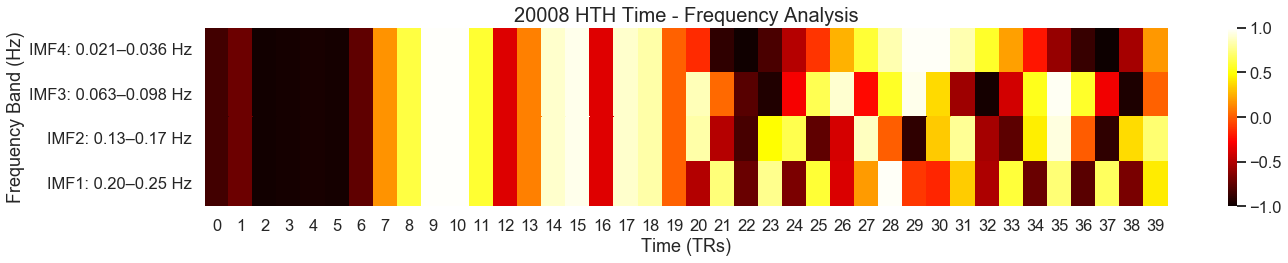

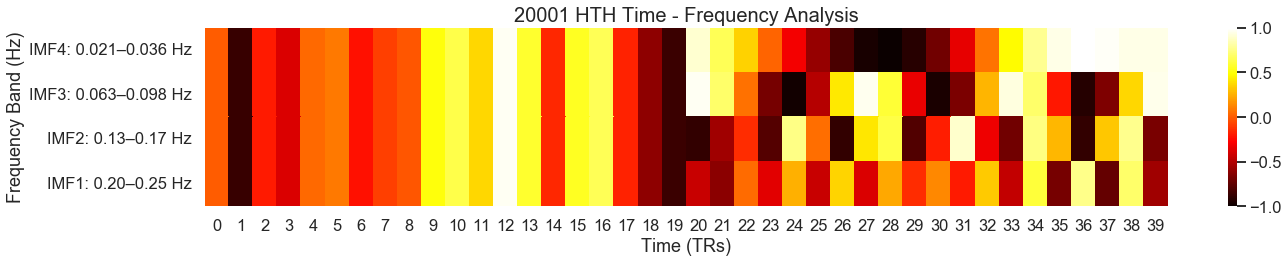

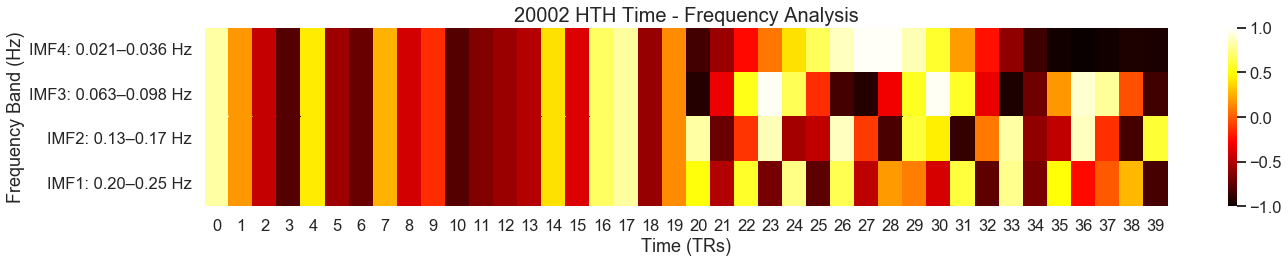

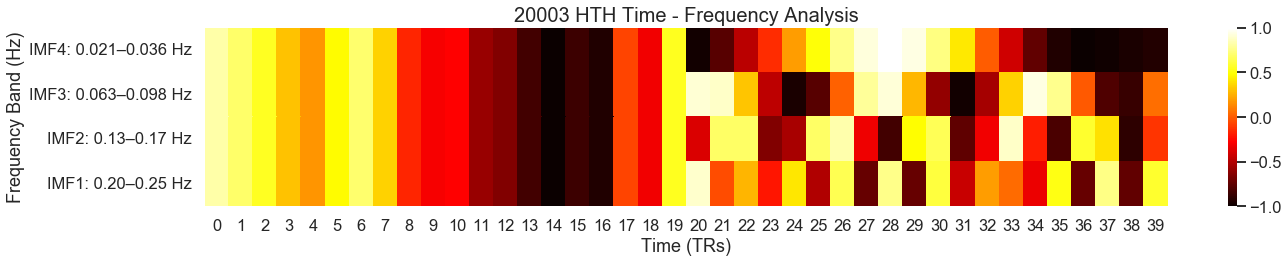

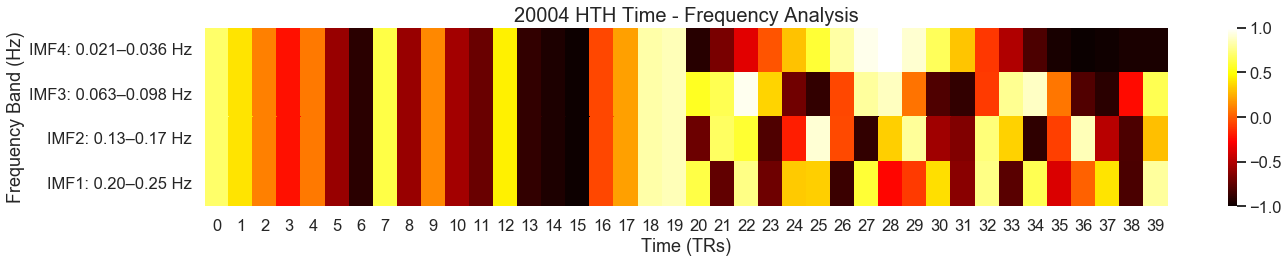

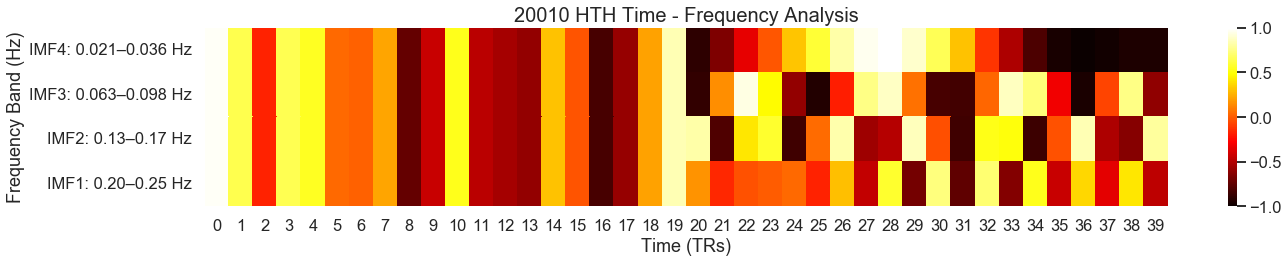

In [253]:
roi = 'HTH'
for sub, df in faze[roi].items():
    df = pd.DataFrame.from_dict(df, orient='index')
#         pdb.set_trace()
    plotzing(df, roi, sub)

In [557]:
raw_insulin = get_subject_roi(sub_timeseries, 'insulin_uIU_mL').dropna()

In [271]:
faze['Pu'].keys()

dict_keys(['20008', '20001', '20002', '20003', '20004', '20010'])

In [292]:
pd.DataFrame.from_dict(faze['HTH']['20008'])

,IMF4: 0.021–0.036 Hz,IMF3: 0.063–0.098 Hz,IMF2: 0.13–0.17 Hz,IMF1: 0.20–0.25 Hz
0,-0.833764,-0.833764,-0.833764,-0.833764
1,-0.708779,-0.708779,-0.708779,-0.708779
2,-0.974969,-0.974969,-0.974969,-0.974969
3,-0.964911,-0.964911,-0.964911,-0.964911
4,-0.959480,-0.959480,-0.959480,-0.959480
5,-0.966824,-0.966824,-0.966824,-0.966824
6,-0.746754,-0.746754,-0.746754,-0.746754
7,0.168825,0.168825,0.168825,0.168825
8,0.624233,0.624233,0.624233,0.624233
9,0.989119,0.989119,0.989119,0.989119


In [295]:
total_df = []
for sub, data in faze['HTH'].items():
    x = pd.DataFrame.from_dict(data)
    x['sub'] = sub
    total_df.append(x)
#     for freq, df in data.items():
#         total_df.

In [296]:
df = pd.concat(total_df)

In [297]:
df.loc[df['sub'] == '20001']['IMF4: 0.021–0.036 Hz']

0     0.006586
1    -0.862302
2    -0.190007
3    -0.375401
4     0.043195
5     0.090183
6    -0.225658
7    -0.083262
8    -0.011127
9     0.511704
10    0.637170
11    0.372647
12    0.973146
13    0.584488
14   -0.155737
15    0.555792
16    0.658278
17   -0.166166
18   -0.607225
19   -0.856112
20    0.904411
21    0.662969
22    0.356253
23    0.025810
24   -0.296898
25   -0.584446
26   -0.811835
27   -0.955771
28   -0.994458
29   -0.908847
30   -0.688092
31   -0.343013
32    0.075746
33    0.478728
34    0.780109
35    0.946074
36    0.997474
37    0.981630
38    0.950151
39    0.946657
Name: IMF4: 0.021–0.036 Hz, dtype: float32

In [306]:
df.columns[0:-1]

Index(['IMF4: 0.021–0.036 Hz', 'IMF3: 0.063–0.098 Hz', 'IMF2: 0.13–0.17 Hz',
       'IMF1: 0.20–0.25 Hz'],
      dtype='object')

IMF4: 0.021–0.036 Hz
IMF3: 0.063–0.098 Hz
IMF2: 0.13–0.17 Hz
IMF1: 0.20–0.25 Hz


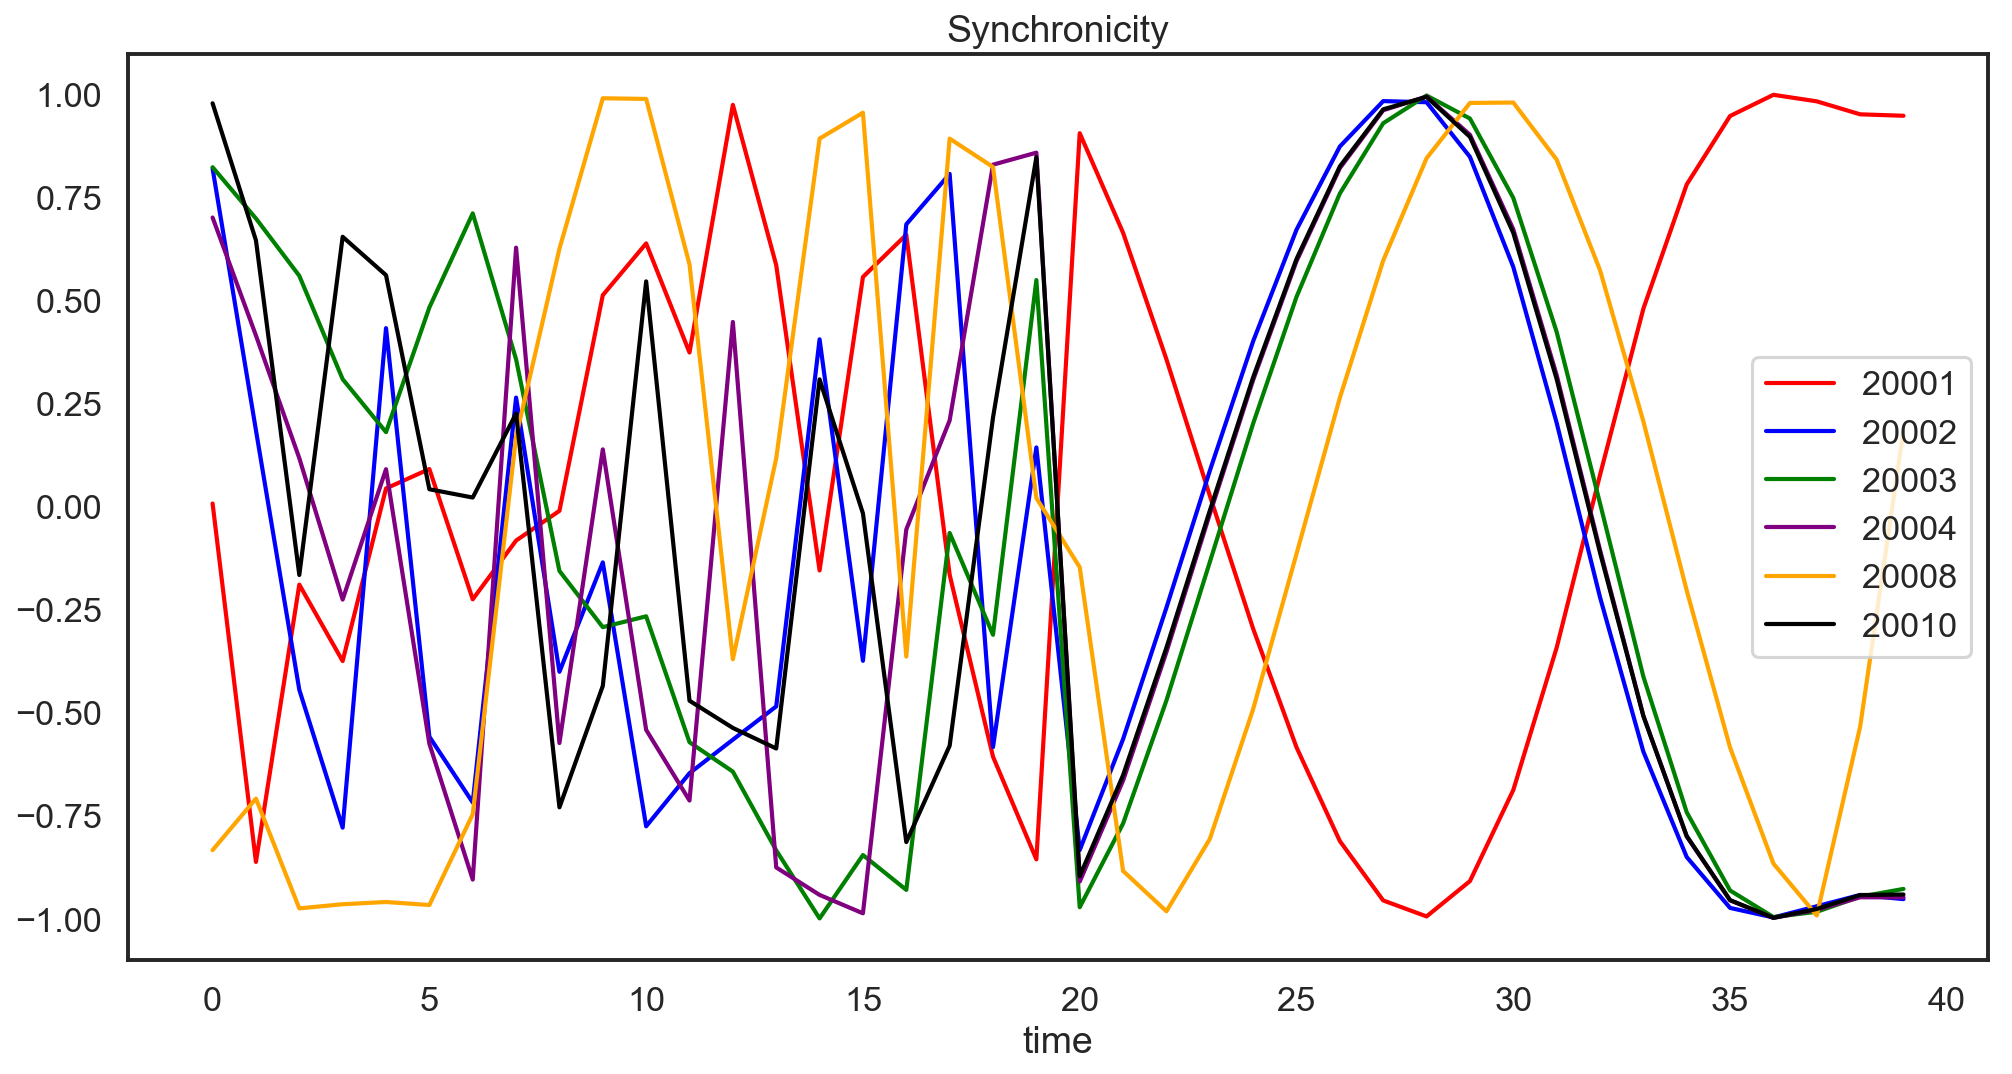

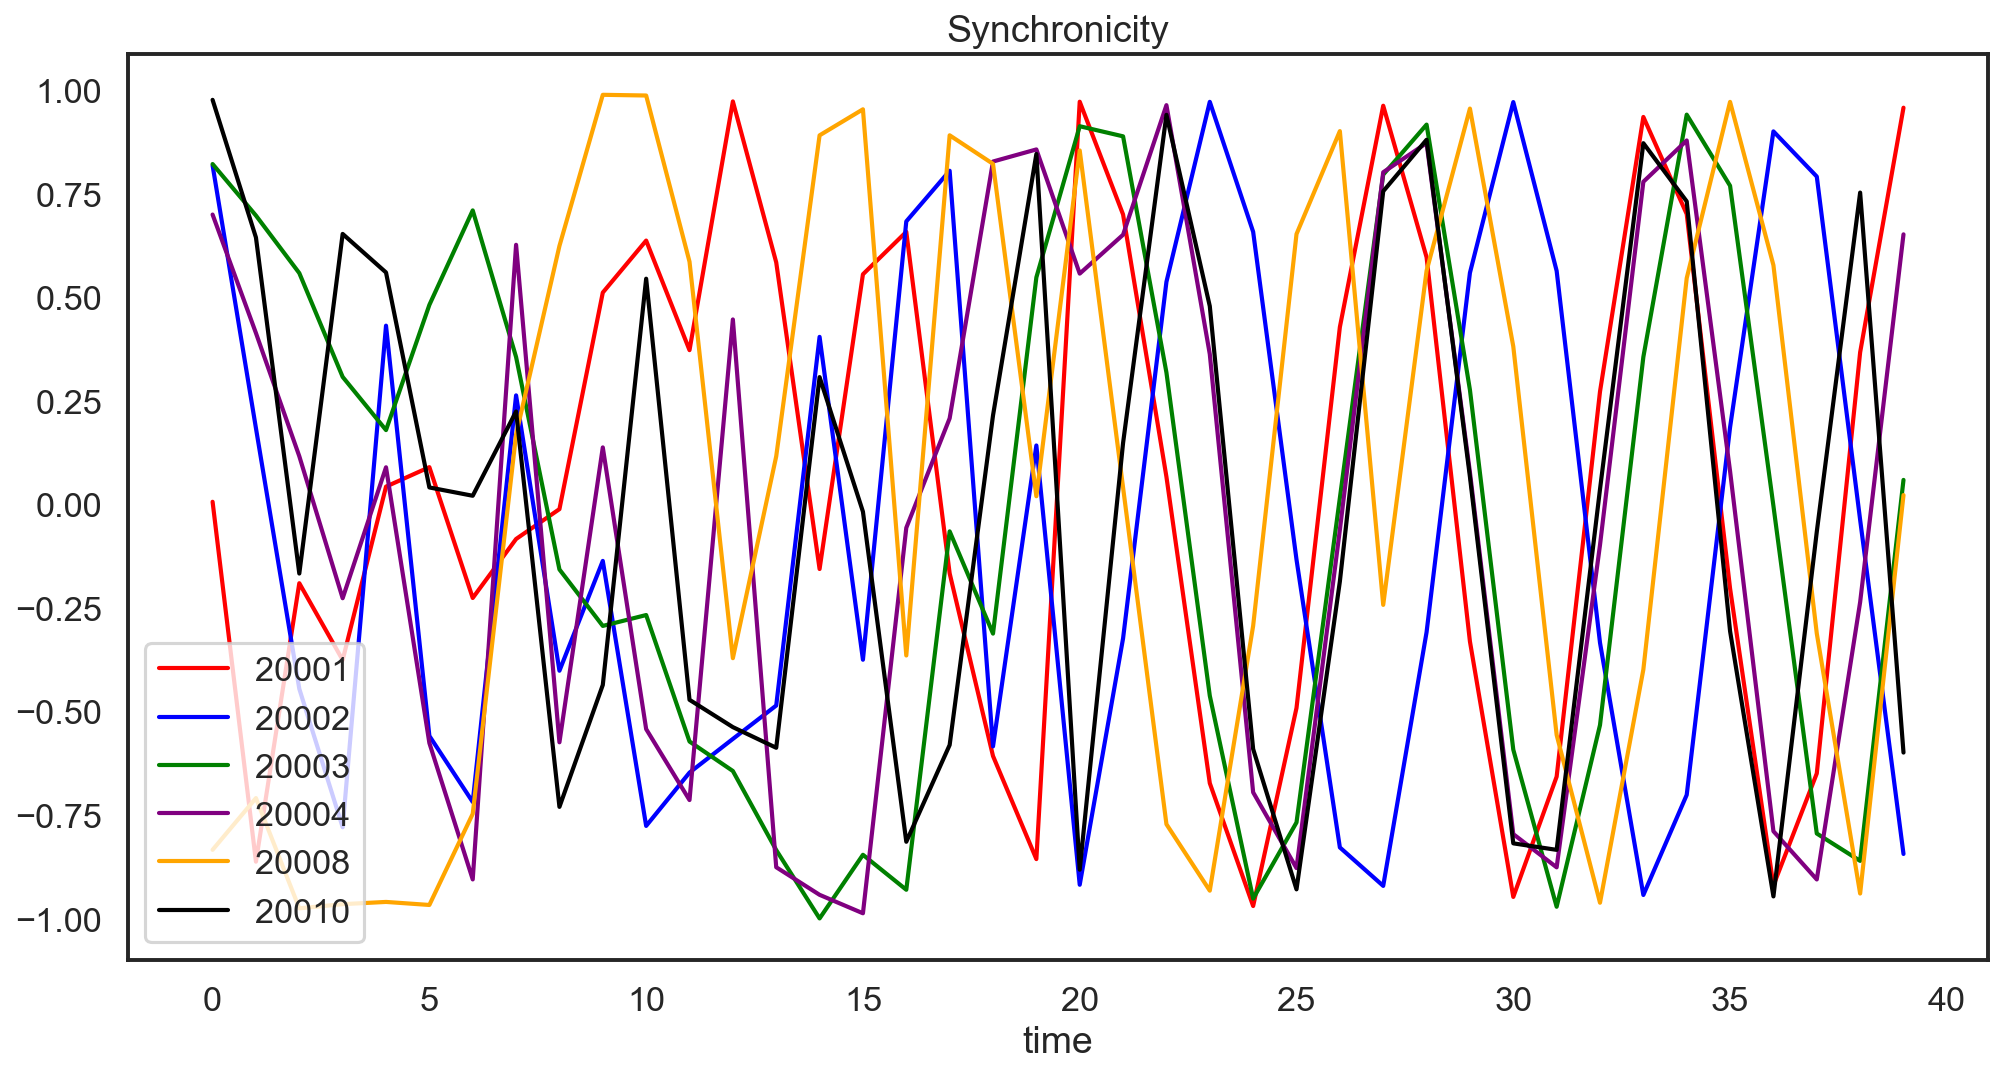

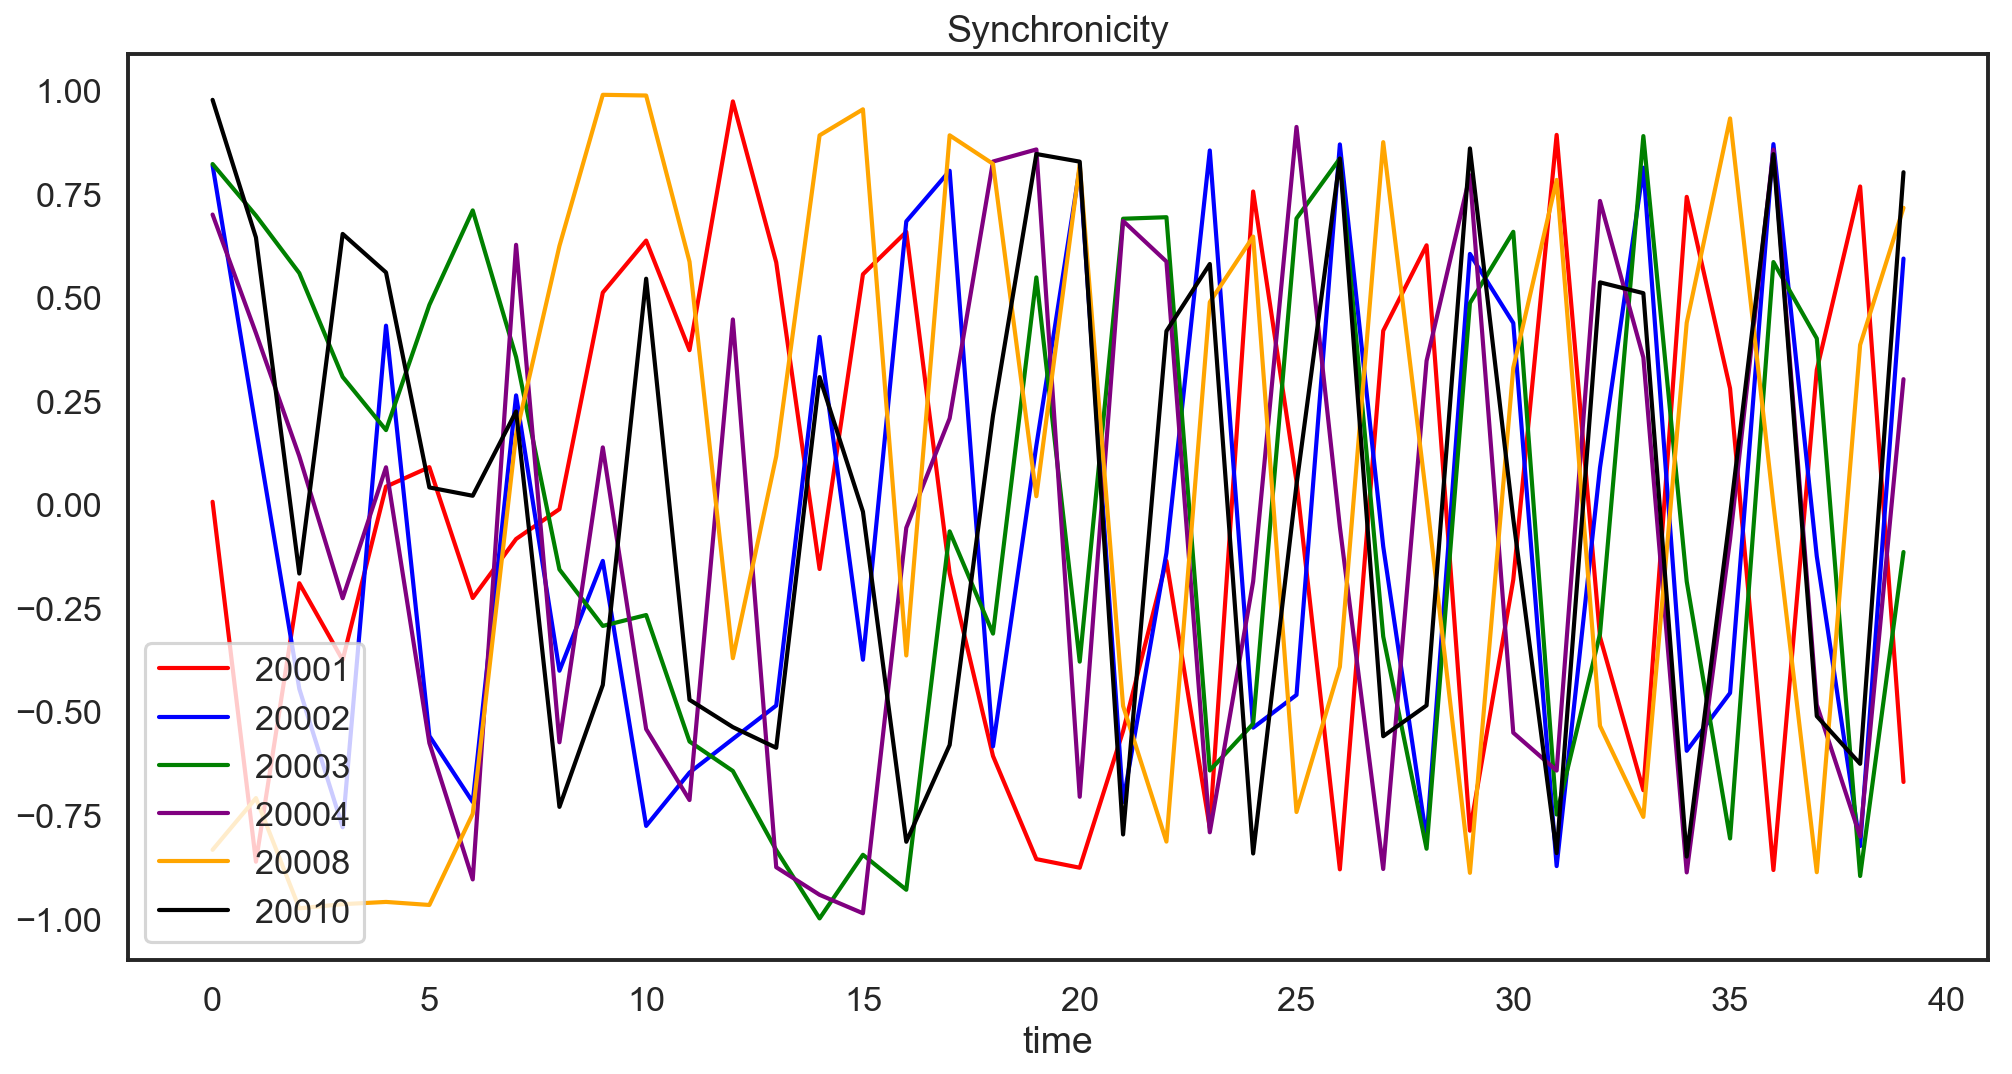

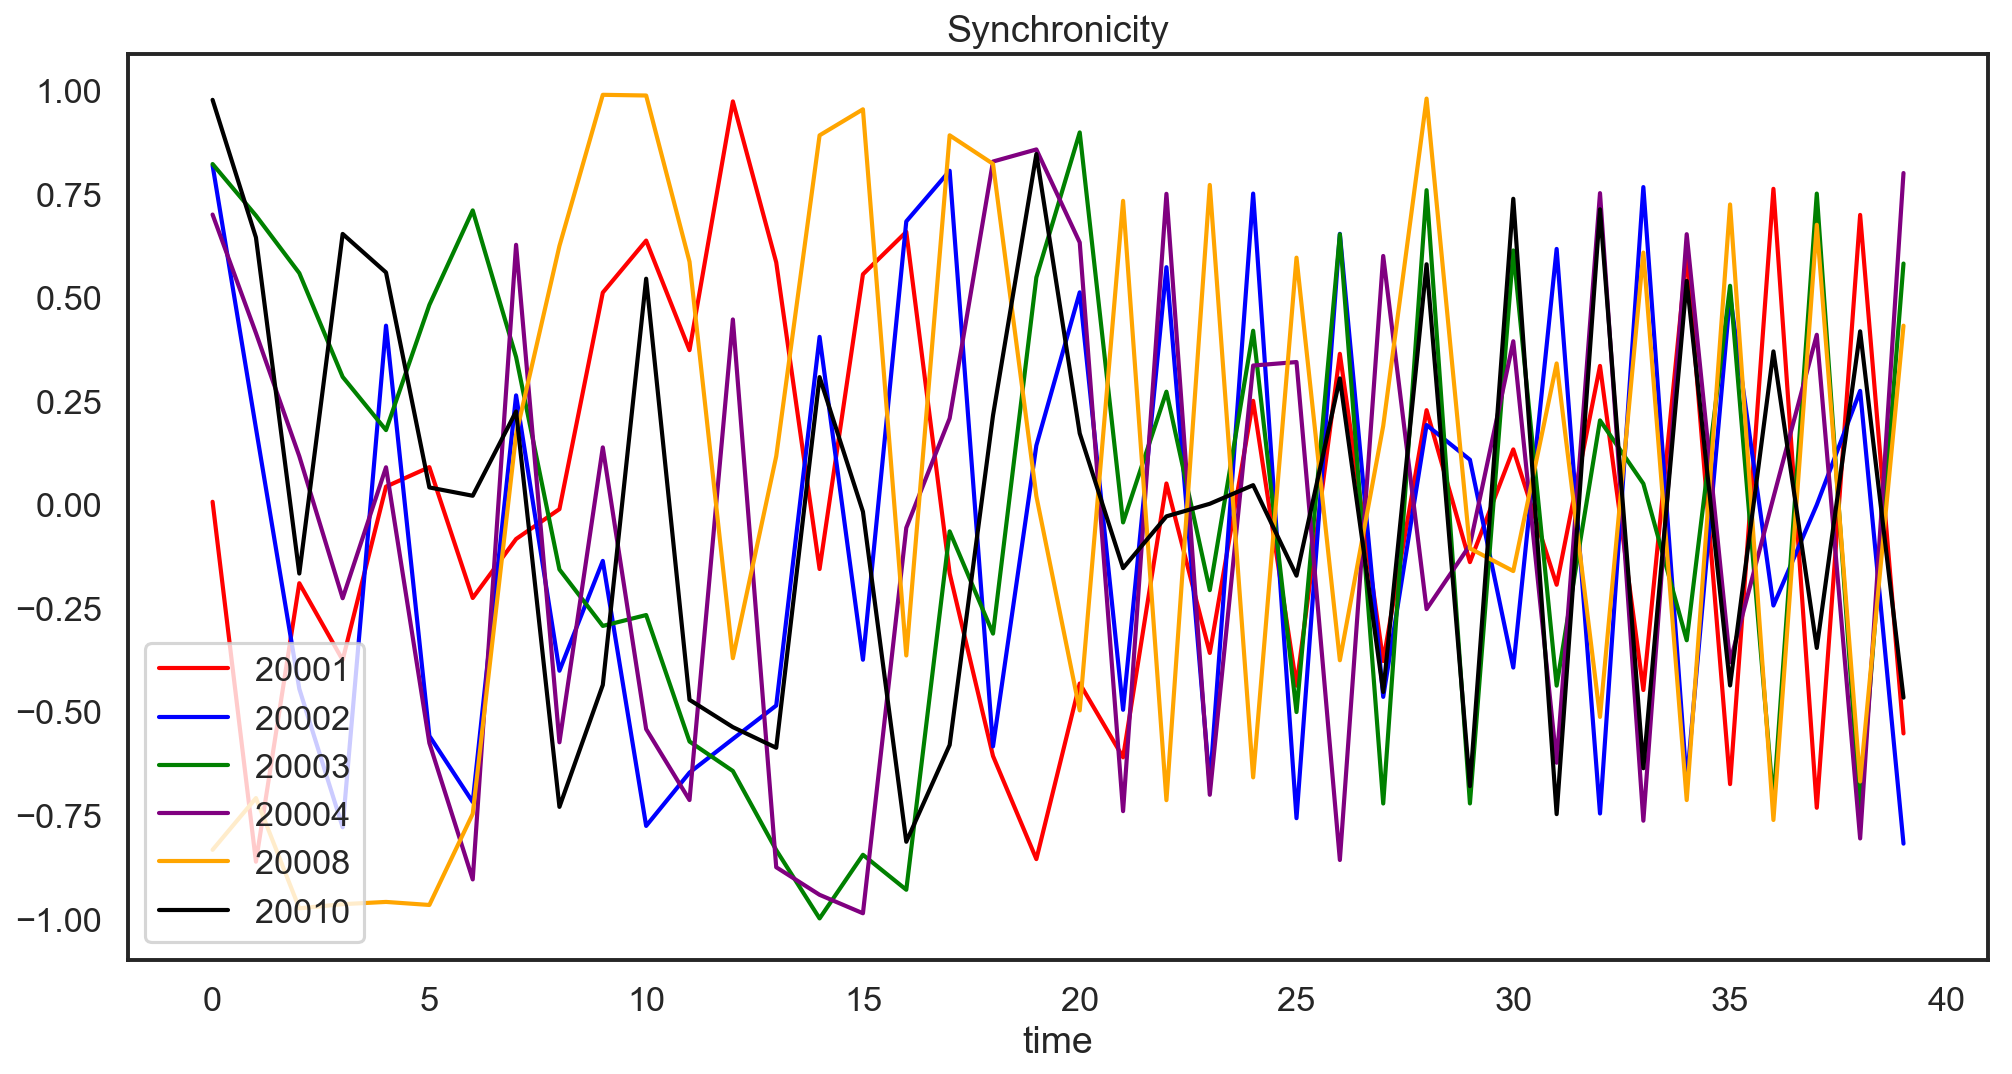

In [310]:
for x in df.columns[0:-1]:
    print(x)
    plt.figure(figsize=(16, 8), dpi=150)

    df.loc[df['sub'] == '20001'][x].plot(label='20001', color = 'red')
    df.loc[df['sub'] == '20002'][x].plot(label='20002', color = 'blue')
    df.loc[df['sub'] == '20003'][x].plot(label='20003', color = 'green')
    df.loc[df['sub'] == '20004'][x].plot(label='20004', color = 'purple')
    df.loc[df['sub'] == '20008'][x].plot(label='20008', color = 'orange')
    df.loc[df['sub'] == '20010'][x].plot(label='20010', color = 'black')

    #total_df[['20001','20002','20003','20004']].mean(axis = 1).plot(label='mean insulin', color = 'black')
    # adding title to the plot
    plt.title('Synchronicity')

    # adding Label to the x-axis
    plt.xlabel('time')

    # adding legend to the curve
    plt.legend()

# Functional connectivity, ISPS

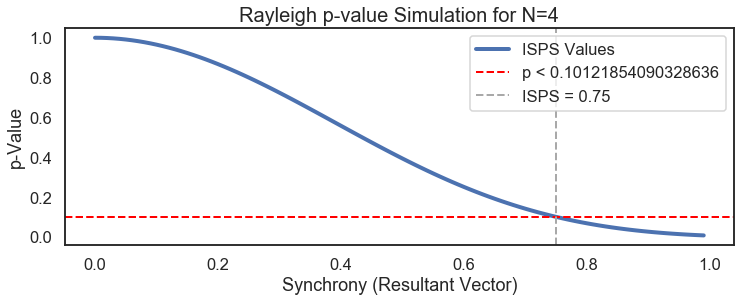

In [74]:
n = 4
R = np.arange(0,1, .01)
Z = n*(R**2)
thr = 75
p = np.exp(-1*Z)*(1 + (2*Z - Z**2)/(4*n) - (24*Z - 132*Z**2 +76*Z**3 - 9*Z**4)/(288*n**2))

plt.figure(figsize=(12, 4))
plt.plot(R, p, linewidth=4)
plt.axhline(p[thr], linestyle='--', color='red')
plt.axvline(R[thr], linestyle='--', color='darkgrey')
plt.ylabel('p-Value', fontsize=18)
plt.xlabel('Synchrony (Resultant Vector)', fontsize=18)
plt.title('Rayleigh p-value Simulation for N=4', fontsize=20)
plt.legend(['ISPS Values', 'p < %s'%p[thr], 'ISPS = %s'%R[thr]])

In [75]:
def bootstrap_subject_matrix(similarity_matrix, random_state=None):
    '''This function shuffles subjects within a similarity matrix based on recommendation by Chen et al., 2016'''
    
    random_state = check_random_state(random_state)
    n_sub = similarity_matrix.shape[0]
    bootstrap_subject = sorted(random_state.choice(np.arange(n_sub), size=n_sub, replace=True))
    return similarity_matrix[bootstrap_subject, :][:, bootstrap_subject]


In [168]:
synchrony = {}
for roi in heady:
    sstats = isps(get_subject_roi(sub_timeseries, roi).dropna(), low_cut=0.01, high_cut=0.027, sampling_freq=1/tr)
    synchrony[roi] = sstats['vector_length']
synchrony = pd.DataFrame(synchrony)

In [170]:
sync = Adjacency(1 - pairwise_distances(synchrony.T, metric='correlation'), matrix_type='similarity')

In [171]:
syn = 1 - pairwise_distances(synchrony.T, metric='correlation')

In [173]:
boots = []
for x in range(50000):
    X = bootstrap_subject_matrix(syn, random_state=x)
    boots.append(X)

In [175]:
null = np.asarray(boots)

In [176]:
output = np.mean(null, axis=0)

In [177]:
from scipy import stats
ttest = stats.ttest_ind(syn, output,equal_var=False)







In [192]:
# f,a = plt.subplots(nrows = len(frequencies), figsize=(15,10))
tr = 1
frequencies = [(0.01, 0.027),(0.027, 0.073),(0.073, 0.198),(0.198, 0.25),(64,200)]
sync_freq = {}
for i,cutoff in enumerate(frequencies):
    sync_freq[i] = {}
    for roi in heady:
        sync_freq[i][roi] = isps(get_subject_roi(sub_timeseries, roi).dropna(), low_cut=cutoff[0], high_cut=cutoff[1], sampling_freq=1/tr, order=5)['vector_length']
#     phase_synchrony_brain = roi_to_brain(pd.DataFrame(synchrony).mean(), mask_x)
#     phase_synchrony_brain.plot(cmap='RdBu_r', vmax=1, axes=a[i], threshold=R[thr], title=f"Frequency cutoff: {cutoff[0]} - {cutoff[1]}")
    
    
    
    
    
    
    

In [199]:
sync_freq[2]['insulin_uIU_mL'] 

array([0.50040156, 0.48510572, 0.5121564 , 0.499997  , 0.43505806,
       0.34904328, 0.28216434, 0.24340145, 0.3232988 , 0.4968507 ,
       0.3140894 , 0.2872806 , 0.33691052, 0.37036273, 0.41550535,
       0.46606186, 0.57808256, 0.62036365, 0.5408368 , 0.5003427 ,
       0.50134283, 0.6409587 , 0.80034775, 0.84974086, 0.89418465,
       0.94920045, 0.96806294, 0.8864918 , 0.8186344 , 0.77479184,
       0.72758836, 0.6339706 , 0.76402897, 0.72832114, 0.717066  ,
       0.71614474, 0.6713447 , 0.61203265, 0.5677442 , 0.3769281 ,
       0.11719944, 0.00362108], dtype=float32)

In [202]:
frequencies[1]

(0.027, 0.073)

In [191]:
synchrony

{'Pu': array([0.05339755, 0.03477291, 0.06705859, 0.12392807, 0.12760642,
        0.10364201, 0.09616869, 0.11205848, 0.10284963, 0.05588742,
        0.02441181, 0.05113401, 0.10038677, 0.21373513, 0.3135028 ,
        0.36944243, 0.43626913, 0.5324426 , 0.6188363 , 0.66424894,
        0.684663  , 0.6661215 , 0.59994656, 0.49659154, 0.39939657,
        0.36159113, 0.3569264 , 0.3494368 , 0.34381294, 0.36288357,
        0.38327432, 0.37192094, 0.35411733, 0.3910388 , 0.4196718 ,
        0.4214668 , 0.5386217 , 0.43880573, 0.39620632, 0.46208078,
        0.41419572, 0.3615618 ], dtype=float32),
 'Ca': array([0.09949251, 0.07284872, 0.16193826, 0.23177966, 0.22398357,
        0.21501578, 0.22228055, 0.23354132, 0.2105539 , 0.18751754,
        0.19457957, 0.19941613, 0.17972772, 0.1636817 , 0.17397794,
        0.18352862, 0.17895046, 0.19228029, 0.234163  , 0.25468123,
        0.24583758, 0.24871093, 0.28950566, 0.34760708, 0.4063793 ,
        0.44897935, 0.4718791 , 0.48735204, 0.49781615,

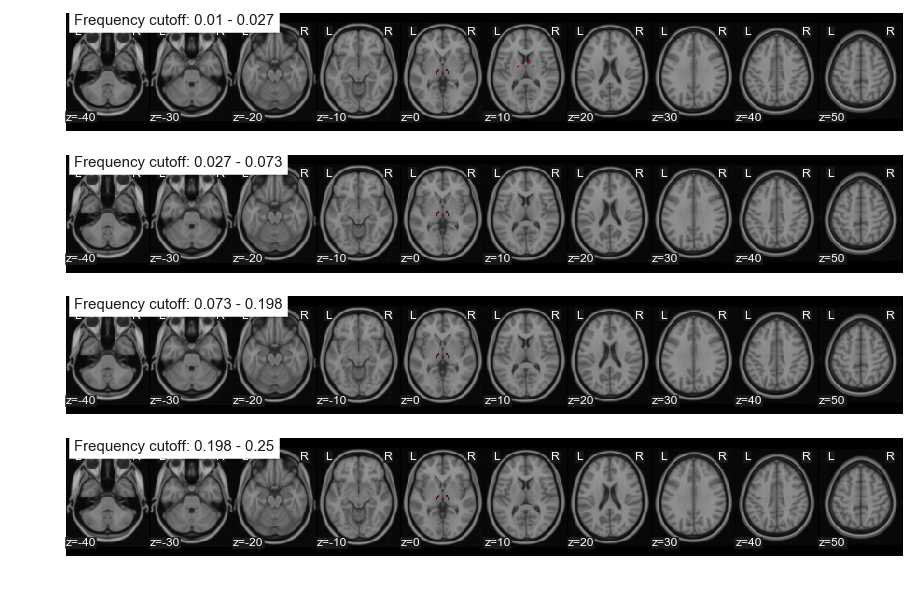

In [88]:
tr = 1
roi = 'insulin_uIU_mL'

f,a = plt.subplots(nrows = len(frequencies), figsize=(15,10))
for i,cutoff in enumerate(frequencies):
    synchrony = {}
    for roi in heady:
        synchrony[roi] = isps(get_subject_roi(sub_timeseries, roi).dropna(), low_cut=cutoff[0], high_cut=cutoff[1], sampling_freq=1/tr, order=5)['vector_length']
    phase_synchrony_brain = roi_to_brain(pd.DataFrame(synchrony).mean(), mask_x)
    phase_synchrony_brain.plot(cmap='RdBu_r', vmax=1, axes=a[i], threshold=R[thr], title=f"Frequency cutoff: {cutoff[0]} - {cutoff[1]}")


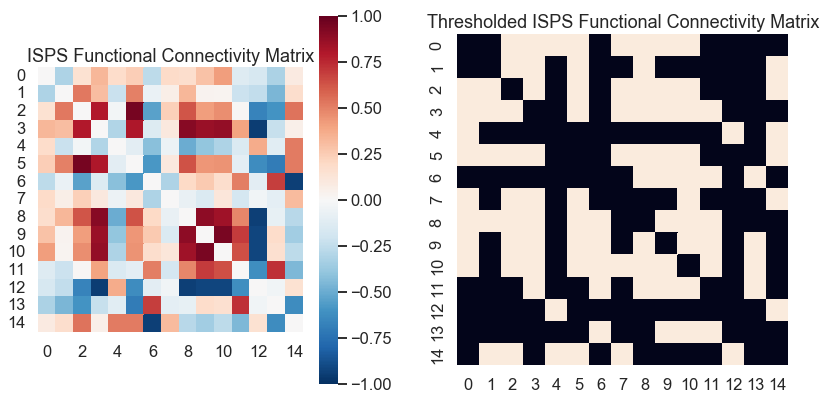

In [186]:
f,a = plt.subplots(ncols=2, figsize=(12, 6))

sync.plot(vmin=-1, vmax=1, cmap='RdBu_r', axes=a[0], cbar=True)
sync.threshold(upper = .1, binarize=True).plot(axes=a[1], cbar=False)
a[0].set_title('ISPS Functional Connectivity Matrix', fontsize=18)
a[1].set_title('Thresholded ISPS Functional Connectivity Matrix', fontsize=18)
plt.tight_layout()

In [187]:
heady[11]

'MN'

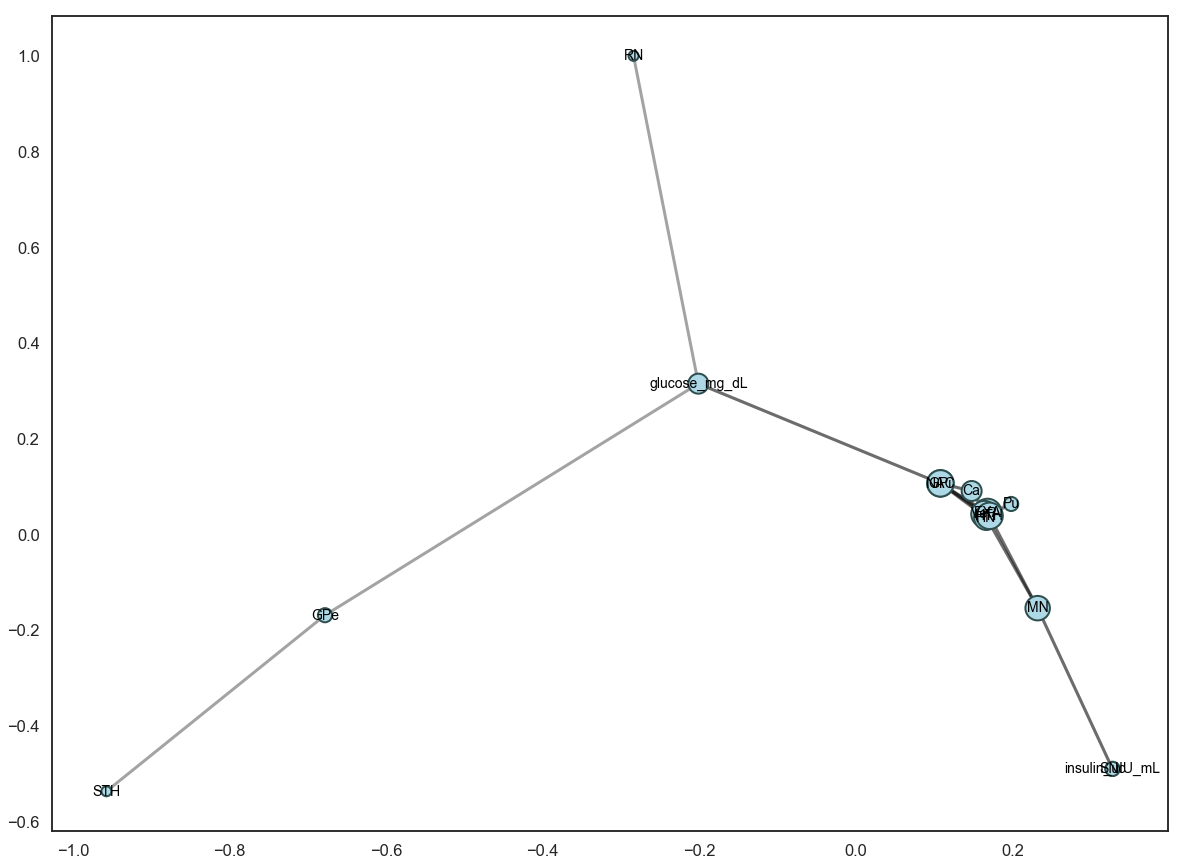

In [188]:
plot_network(sync.threshold(upper = .3, binarize=True))

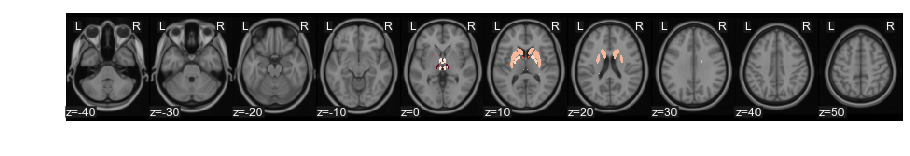

In [91]:
degree = pd.Series(dict(sync.threshold(upper=.2, binarize=True).to_graph().degree()))
brain_degree = roi_to_brain(degree, mask_x)
brain_degree.plot(cmap='RdBu_r')

https://www.frontiersin.org/articles/10.3389/fnins.2019.00900/full